In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import bte

To replicate this analysis, you will need to obtain the relevant phylogeny and generate novel lineages. Instead of applying the full Snakemake pipeline for Pansgo designations, this can be done directly using the core implementation script at https://github.com/jmcbroome/autolin/blob/main/propose_sublineages.py. 

```

wget http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/public-latest.all.masked.pb.gz

python3 propose_sublineages.py -i public-2022-12-11.all.masked.pb.gz -c -r -o public-2022-12-11.fresh_annotations.pb -d fresh_annotations.tsv -l fresh_annotations.labels.tsv -t 1 -m 10 -u 0.999 --verbose > fresh_annotations.log

usher_to_taxonium -i public-2022-12-11.fresh_annotations.pb -o public-2022-12-11.autolabeled.jsonl.gz -m combined_cladesamples.extended.tsv -c annotation_1,annotation_2,auto_annotation,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12 -t Automated_Lineages --key_column sample

```

Once this is done, we load in the original phylogeny, and apply a simple algorithm to identify, for each node on the tree, the number of descendent tips.

In [2]:
t = bte.MATree("public-2022-12-11.all.masked.pb.gz")
t

Finished 'from_pb' in 56.8928 seconds


MATree object with 6518699 leaves.

In [3]:
node_desc_counts = {}
for n in t.breadth_first_expansion(reverse=True):
    if n.is_leaf():
        node_desc_counts[n.id] = 1
    else:
        node_desc_counts[n.id] = sum([node_desc_counts[c.id] for c in n.children])
len(node_desc_counts)

7835901

We then load in the mappings of the pango (and nextstrain) clades and the new Autolin lineages. These files can be obtained from the public phylogeny and from the newly annotated phylogeny with `matUtils extract -C`.

In [30]:
auto_pdf = pd.read_csv('fresh_annotations_paths.txt',sep='\t',usecols=[0,1])
pango_pdf = pd.read_csv('pango_paths.txt',sep='\t',usecols=[0,1])
#additionally, remove the "auto." prefix from the names, if present.
auto_pdf['clade'] = auto_pdf.clade.apply(lambda x:x.strip("auto."))
auto_pdf

,clade,root_id
0,L,node_1
1,L.609,node_3
2,L.512,node_11
3,L.685,node_51
4,L.464,node_59
...,...,...
170360,L.2.1.2.4.1.1.3.1,node_1175339
170361,L.2.1.2.4.1.1.1.1.1.2.1,node_1175511
170362,L.2.1.2.4.1.1.1.1.1.1.1,node_1175474
170363,L.2.1.2.4.1.1.3.1.1,node_1175348


We then compute the pairwise Jaccard similarities for each pair of Autolin and Pango/Nextclade lineages that overlap to any degree.

We can speed up this computation by taking advantage of the nature of the shared phylogeny. Since the set of descendent samples is defined by a specific node, and the descendents of the parent of that specific node also includes all descendents of the node by definition, we only need ancestral node identifiers to identify overlapping sample sets. 

Additionally, as lineages are defined as single ancestral nodes on the tree in both cases, there cannot be a case of partial overlap between two lineages. Two lineages can only be:

1. Non-overlapping, with no tips in common 
2. Identical, with all tips in common 
3. Encompassing, where all of the tips in one lineage are present in the other, but not vice versa. 

In the first case, Jaccard is 0; in the second, its 1. We can identify the third case by examining each ancestor of a lineage's root node and checking whether that ancestor is the root of a lineage in the comparison set; if so, that ancestor's descendents will necessarily encompass all the descendents of the first lineage's root node. The set intersection between their descendents is the number of descendent tips of the ancestor, the union is the number of tips of the original descendent lineage, and therefore the jaccard index is simply the first number of descendents divided by the second.

In [31]:
pango_ancestors = pango_pdf.set_index('root_id')['clade'].to_dict()
auto_ancestors = auto_pdf.set_index('root_id')['clade'].to_dict()

In [32]:
pairdf = {k:[] for k in ['pango_lineage','auto_lineage','jaccard','ancestral','ancestral_size','descendent_size']}

for i,row in auto_pdf.iterrows():
    smaller_count = node_desc_counts[row.root_id]
    for anc in t.rsearch(row.root_id,include_self=True):
        pango = pango_ancestors.get(anc.id,None)
        if pango != None:
            bigger_count = node_desc_counts[anc.id]
            pairdf['pango_lineage'].append(pango)
            pairdf['auto_lineage'].append(row.clade)
            pairdf['jaccard'].append(smaller_count/bigger_count)
            pairdf['ancestral'].append('pango')
            pairdf['ancestral_size'].append(bigger_count)
            pairdf['descendent_size'].append(smaller_count)

            
for i,row in pango_pdf.iterrows():
    smaller_count = node_desc_counts[row.root_id]
    for anc in t.rsearch(row.root_id,include_self=True):
        auto = auto_ancestors.get(anc.id,None)
        if auto != None:
            bigger_count = node_desc_counts[anc.id]
            pairdf['pango_lineage'].append(row.clade)
            pairdf['auto_lineage'].append(auto)
            pairdf['jaccard'].append(smaller_count/bigger_count)
            pairdf['ancestral'].append('auto')
            pairdf['ancestral_size'].append(bigger_count)
            pairdf['descendent_size'].append(smaller_count)

pairdf = pd.DataFrame(pairdf)
pairdf

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size
0,B,L,1.000000,pango,6518699,6518699
1,B.15,L.609,1.000000,pango,46,46
2,B,L.609,0.000007,pango,6518699,46
3,B.20,L.512,1.000000,pango,43,43
4,B,L.512,0.000007,pango,6518699,43
...,...,...,...,...,...,...
969719,BQ.1.8.2,L.2.1.1.3,0.009528,auto,27812,265
969720,BQ.1.8.2,L.2.1.1,0.000544,auto,486908,265
969721,BQ.1.8.2,L.2.1,0.000167,auto,1587168,265
969722,BQ.1.8.2,L.2,0.000104,auto,2558909,265


The above treats Pango and Nextclade clades interchangeably. We can identify whether a given clade is a Nextstrain clade or a Pango lineage by its position in the annotation vector in the original phylogeny.

In [33]:
nextstrain_clades = []
for n in t.depth_first_expansion():
    if len(n.annotations) > 0:
        if n.annotations[0] != "":
            nextstrain_clades.append(n.annotations[0])
nextstrain_clades

['19A',
 '19B',
 '20A',
 '21B (Kappa)',
 '21A (Delta)',
 '21J (Delta)',
 '21I (Delta)',
 '20E (EU1)',
 '21D (Eta)',
 '20C',
 '21C (Epsilon)',
 '21F (Iota)',
 '20H (Beta,V2)',
 '21H (Mu)',
 '20G',
 '20B',
 '21E (Theta)',
 '20D',
 '21G (Lambda)',
 '20F',
 '21M (Omicron)',
 '21K (Omicron)',
 '21L (Omicron)',
 '22A (Omicron)',
 '22B (Omicron)',
 '22E (Omicron)',
 '22F (Omicron)',
 '22D (Omicron)',
 '22C (Omicron)',
 '20I (Alpha,V1)',
 '20J (Gamma,V3)']

In [34]:
pairdf['is_nextstrain'] = pairdf['pango_lineage'].apply(lambda x:x in nextstrain_clades)
pairdf

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
0,B,L,1.000000,pango,6518699,6518699,False
1,B.15,L.609,1.000000,pango,46,46,False
2,B,L.609,0.000007,pango,6518699,46,False
3,B.20,L.512,1.000000,pango,43,43,False
4,B,L.512,0.000007,pango,6518699,43,False
...,...,...,...,...,...,...,...
969719,BQ.1.8.2,L.2.1.1.3,0.009528,auto,27812,265,False
969720,BQ.1.8.2,L.2.1.1,0.000544,auto,486908,265,False
969721,BQ.1.8.2,L.2.1,0.000167,auto,1587168,265,False
969722,BQ.1.8.2,L.2,0.000104,auto,2558909,265,False


13 of the 30 Nextstrain clades have a near-exact or exact matching Autolin lineage, though the case of 19A and 20A is trivial. These include major VOC such as Omicron, Delta, Epsiolon, Mu, and Iota. Some of the smaller VOC are not replicated independently by Autolin, however, such as Eta and Lambda. 

In [35]:
best_matches = pairdf.sort_values("jaccard",ascending=False).drop_duplicates('pango_lineage')
best_matches[best_matches.is_nextstrain].sort_values('jaccard',ascending=False)

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
966259,22D (Omicron),L.2.1.6,1.000000,auto,8337,8337,True
966172,22A (Omicron),L.2.1.4,1.000000,auto,78100,78100,True
966189,22F (Omicron),L.2.1.9.1,1.000000,auto,1609,1609,True
64992,21I (Delta),L.4,1.000000,pango,191745,191745,True
962355,19A,L,1.000000,auto,6518699,6518699,True
964590,21B (Kappa),L.40,1.000000,auto,1005,1005,True
963698,21E (Theta),L.285,1.000000,auto,46,46,True
964075,20F,L.9,1.000000,auto,11458,11458,True
964418,20G,L.6.1,1.000000,auto,73286,73286,True
964856,21C (Epsilon),L.6.2,1.000000,auto,41515,41515,True


Excluding Nextstrain clades and artifactual annotations (including "misc" and "proposed" tags), there are 1978 annotated Pango lineages in this phylogeny.

In [36]:
pango_pairdf = pairdf[(~pairdf.is_nextstrain) & (pairdf.pango_lineage.apply(lambda x:('misc' not in x) and ('proposed' not in x)))]
pango_pairdf.pango_lineage.nunique()

1978

We can identify the highest matching jaccard for each of these groups by sorting and dropping entries for a specific Pango lineage after the first one.

In [37]:
best_pango_matches = pango_pairdf.sort_values("jaccard",ascending=False).drop_duplicates('pango_lineage')

<AxesSubplot: ylabel='Frequency'>

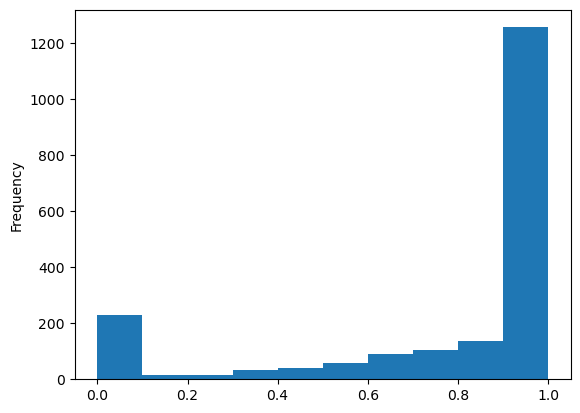

In [38]:
best_pango_matches.jaccard.plot(kind='hist')

In [39]:
best_pango_matches[best_pango_matches.jaccard == 1]

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
0,B,L,1.0,pango,6518699,6518699,False
963253,B.1.1.382,L.360.1,1.0,auto,22,22,False
963246,B.1.1.258,L.492,1.0,auto,27,27,False
963241,B.1.1.426,L.565.1,1.0,auto,18,18,False
963238,B.1.1.413,L.214.1,1.0,auto,51,51,False
...,...,...,...,...,...,...,...
541791,AY.43.3,L.1.6.1.35,1.0,pango,261,261,False
541395,AY.43.9,L.1.6.26,1.0,pango,540,540,False
540894,AY.43.5,L.1.158.5,1.0,pango,12,12,False
967997,BF.10,L.2.1.1.1.2.1.3,1.0,auto,10489,10489,False


In [40]:
best_pango_matches[(best_pango_matches.jaccard == 1) & (best_pango_matches.pango_lineage.apply(lambda x:("misc" not in x) and ('proposed' not in x)))]

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
0,B,L,1.0,pango,6518699,6518699,False
963253,B.1.1.382,L.360.1,1.0,auto,22,22,False
963246,B.1.1.258,L.492,1.0,auto,27,27,False
963241,B.1.1.426,L.565.1,1.0,auto,18,18,False
963238,B.1.1.413,L.214.1,1.0,auto,51,51,False
...,...,...,...,...,...,...,...
541791,AY.43.3,L.1.6.1.35,1.0,pango,261,261,False
541395,AY.43.9,L.1.6.26,1.0,pango,540,540,False
540894,AY.43.5,L.1.158.5,1.0,pango,12,12,False
967997,BF.10,L.2.1.1.1.2.1.3,1.0,auto,10489,10489,False


In [41]:
best_pango_matches[(best_pango_matches.jaccard > .5) & (best_pango_matches.jaccard < 1) & (best_pango_matches.pango_lineage.apply(lambda x:("misc" not in x) and ('proposed' not in x)))]


,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
21243,B.1.1.529,L.2,0.999992,pango,2558930,2558909,False
49051,BA.2,L.2.1,0.999900,pango,1587327,1587168,False
12442,B.1.258,L.8.1,0.999850,pango,6659,6658,False
809025,AY.4.2.1,L.1.1.1.1.1,0.999830,pango,17677,17674,False
563509,AY.13,L.4.1.3,0.999801,pango,5028,5027,False
...,...,...,...,...,...,...,...
662788,AY.43.2,L.1.6.1.57,0.511765,pango,170,87,False
11981,B.1.1.217,L.52.2,0.508961,pango,279,142,False
12226,B.1.1.237,L.27.2,0.508772,pango,171,87,False
963715,B.1.1.371,L.222,0.505376,auto,93,47,False


In [70]:
pango_pairdf[pango_pairdf.jaccard > .9].pango_lineage.nunique() / pango_pairdf.pango_lineage.nunique()

0.6349848331648129

In [71]:
pango_pairdf[pango_pairdf.jaccard == 1].pango_lineage.nunique() /pango_pairdf.pango_lineage.nunique()

0.49898887765419614

In [72]:
pango_pairdf[pango_pairdf.jaccard == 1].pango_lineage.nunique(), pango_pairdf.pango_lineage.nunique()

(987, 1978)

Of the 1978 Pango lineages, 987 are perfectly recaptured by a matching auto lineage.

Text(0.5, 1.0, 'Distribution of Best Match Jaccard Indeces for Pango')

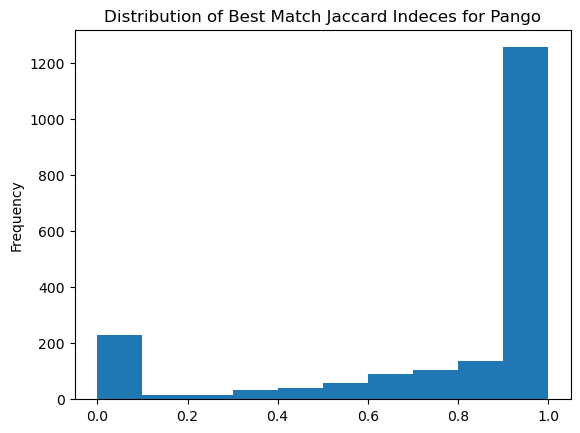

In [46]:
ax = pango_pairdf.sort_values("jaccard",ascending=False).groupby("pango_lineage").jaccard.max().plot(kind='hist')
plt.title("Distribution of Best Match Jaccard Indeces for Pango")

<AxesSubplot: >

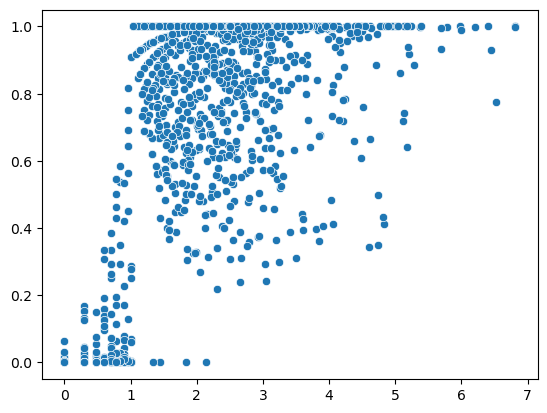

In [55]:
pango_labels = []
pango_sizes = []
jaccard = []
for pango, sdf in pango_pairdf.groupby("pango_lineage"):
    if 'pango' in sdf.ancestral:
        pango_size = sdf[sdf.ancestral == 'pango'].ancestral_size.max()
    else:
        pango_size = sdf[sdf.ancestral == 'auto'].descendent_size.max()
    pango_labels.append(pango)
    pango_sizes.append(np.log10(pango_size))
    jaccard.append(sdf.jaccard.max())
sns.scatterplot(x=pango_sizes,y=jaccard)

Text(0.5, 1.0, 'Size and Jaccard for Pango Lineages')

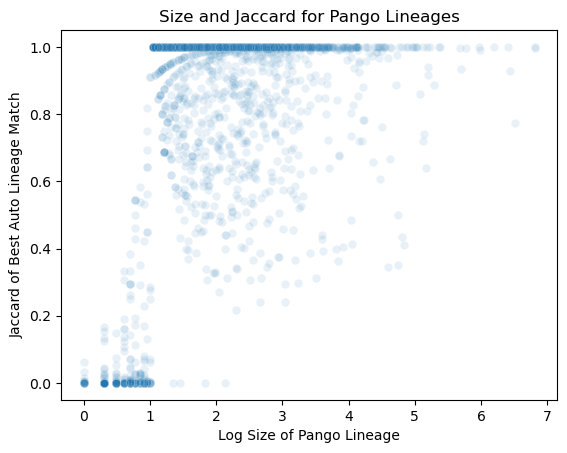

In [66]:
ax = sns.scatterplot(x=pango_sizes,y=jaccard, alpha=.1)
ax.set_xlabel("Log Size of Pango Lineage")
ax.set_ylabel("Jaccard of Best Auto Lineage Match")
ax.set_title("Size and Jaccard for Pango Lineages")

<AxesSubplot: xlabel='Category', ylabel='Log Size'>

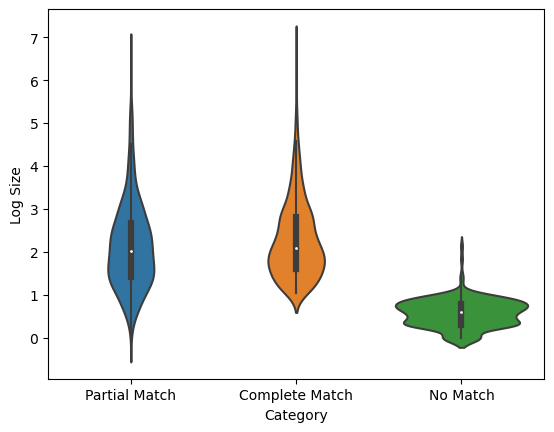

In [49]:
def bin_jacc(j):
    if j < 0.05:
        return "No Match"
    elif j > 0.95:
        return "Complete Match"
    else:
        return "Partial Match"
bdf = pd.DataFrame({'Lineage':pango_labels,'Log Size':pango_sizes,'Jaccard':jaccard})
bdf['Category'] = bdf.Jaccard.apply(bin_jacc)
sns.violinplot(x='Category',y='Log Size',data=bdf)

In [74]:
bdf.Category.value_counts()

Complete Match    1175
Partial Match      586
No Match           217
Name: Category, dtype: int64

In [62]:
bdf[bdf.Category == 'No Match']['Log Size'].describe()

count    217.000000
mean       0.577317
std        0.321563
min        0.000000
25%        0.301030
50%        0.602060
75%        0.778151
max        2.136721
Name: Log Size, dtype: float64

In [65]:
from scipy.stats import percentileofscore as pos
pos(bdf[bdf.Category == 'No Match']['Log Size'], 1)

96.54377880184332

In [50]:
vc = pango_pairdf.sort_values("jaccard",ascending=False).groupby("pango_lineage").jaccard.max()
bad = [i for i in vc.index if vc[i] < 0.01]

In [51]:
bad

['A.11',
 'A.12',
 'A.18',
 'A.2.4',
 'A.2.5.3',
 'A.24',
 'A.7',
 'AG.1',
 'AY.112.3',
 'AY.125.1',
 'AY.19',
 'AY.25.1.1',
 'AY.25.2',
 'AY.39.1.2',
 'AY.39.1.3',
 'AY.39.1.4',
 'AY.4.17',
 'AY.5.6',
 'B.1.1.116',
 'B.1.1.117',
 'B.1.1.121',
 'B.1.1.122',
 'B.1.1.152',
 'B.1.1.169',
 'B.1.1.175',
 'B.1.1.185',
 'B.1.1.201',
 'B.1.1.221',
 'B.1.1.242',
 'B.1.1.27',
 'B.1.1.275',
 'B.1.1.283',
 'B.1.1.325',
 'B.1.1.336',
 'B.1.1.338',
 'B.1.1.339',
 'B.1.1.357',
 'B.1.1.364',
 'B.1.1.381',
 'B.1.1.389',
 'B.1.1.398',
 'B.1.1.421',
 'B.1.1.438',
 'B.1.1.447',
 'B.1.1.448',
 'B.1.1.466',
 'B.1.1.500',
 'B.1.1.506',
 'B.1.1.513',
 'B.1.1.524',
 'B.1.1.54',
 'B.1.1.88',
 'B.1.110.2',
 'B.1.134',
 'B.1.137',
 'B.1.145',
 'B.1.161',
 'B.1.164',
 'B.1.177.12',
 'B.1.177.24',
 'B.1.177.25',
 'B.1.177.39',
 'B.1.177.40',
 'B.1.177.46',
 'B.1.177.59',
 'B.1.177.67',
 'B.1.177.76',
 'B.1.178',
 'B.1.180',
 'B.1.182',
 'B.1.194',
 'B.1.203',
 'B.1.208',
 'B.1.211',
 'B.1.214',
 'B.1.221.3',
 'B.1.

In [52]:
bad_df = pango_pairdf[pango_pairdf.pango_lineage.isin(bad)]
bad_df

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
962386,B.42,L,9.204291e-07,auto,6518699,6,False
962407,B.41,L.20,1.308167e-03,auto,5351,7,False
962408,B.41,L,1.073834e-06,auto,6518699,7,False
962426,B.37,L.20.2,2.702703e-03,auto,1850,5,False
962427,B.37,L.20,9.344048e-04,auto,5351,5,False
...,...,...,...,...,...,...,...
969682,XAQ,L.2.1.3.43,2.409639e-03,auto,415,1,False
969683,XAQ,L.2.1.3,2.783422e-06,auto,359270,1,False
969684,XAQ,L.2.1,6.300530e-07,auto,1587168,1,False
969685,XAQ,L.2,3.907915e-07,auto,2558909,1,False


In [76]:
bad_df[bad_df.descendent_size > 100] #BA.3 is poorly captured by autolin.

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
964966,BA.3,L.2,0.000054,auto,2558909,137,False
964967,BA.3,L,0.000021,auto,6518699,137,False
